<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Rectangular-embedding" data-toc-modified-id="Rectangular-embedding-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Rectangular embedding</a></span></li><li><span><a href="#Self-adjoint-embedding" data-toc-modified-id="Self-adjoint-embedding-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Self-adjoint embedding</a></span></li><li><span><a href="#Spectrogram-embedding" data-toc-modified-id="Spectrogram-embedding-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Spectrogram embedding</a></span></li></ul></div>

## Speech unmixing
(This simulation is associated with Figure 3 and Figure 10 in FCA paper)

In [1]:
push!(LOAD_PATH, "../../src") # change it to your local path
using FCA
using FileIO, WAV, LinearAlgebra, Plots, Statistics

In [2]:
source_num = [1 2]; # pick two -- from 1, 2, 3, 4 ,5
# try different sources here!
source1 = "../soundwave/source$(source_num[1]).wav"
source2 = "../soundwave/source$(source_num[2]).wav"

"../soundwave/source2.wav"

In [3]:
x1, fx1 = wavread(source1)
x2, fx2 = wavread(source2)
min_s1s2_size = min(length(x1), length(x2))

# cut to same length
x1 = x1[1:min_s1s2_size];
x2 = x2[1:min_s1s2_size];

In [4]:
# p1 = plot(x1, label = "")
# p2 = plot(x2, color = "red", label = "")
# plot(p1,p2,layout = (2,1))

In [5]:
A = [sqrt(2) sqrt(2); -sqrt(2) sqrt(2)]/2
x = [x1, x2]
z = A*x

# p3 = plot(z[1], label = "")
# p4 = plot(z[2], color = "red", label = "")
# plot(p3,p4,layout = (2,1))

2-element Array{Array{Float64,1},1}:
 [0.50468, 0.399307, 0.199654, 0.305026, 0.615599, 0.510226, 0.543502, 0.160832, 0.244021, 0.510226  …  -0.216291, -0.183016, -0.00554594, -0.221837, -0.271751, -0.0277297, 0.083189, 0.0499134, 0.138648, -0.2052]    
 [0.421491, 0.32721, 0.160832, 0.277297, 0.598961, 0.549048, 0.582323, 0.199654, 0.293935, 0.571231  …  -0.244021, -0.210746, -0.310572, 0.00554594, 0.0998268, -0.0443675, -0.133102, -0.0221837, -0.0998268, 0.321664]

# Apply ICA

In [6]:
Aica,xest = icf(z)
@show pinv(Aica)*A
@show err_pd(pinv(Aica)*A)

pinv(Aica) * A = [-4.52404 -0.0523886; -0.050726 5.52672]
err_pd(pinv(Aica) * A) = 0.014681673854391612


0.014681673854391612

In [7]:
# p5 = plot(xest[1], label = "")
# p6 = plot(xest[2], color = "red", label = "")
# plot(p1,p2,layout = (2,1))

# Rectangular embedding

In [8]:
# embed vector into rectangular matrix
N,M = 200, 250
Z1 = mat_embed(z[1], (N,M), tpin = "rec", tpout = "rec") # same as reshape in this case
Z2 = mat_embed(z[2], (N,M), tpin = "rec", tpout = "rec") # same as reshape in this case
Z = [Z1, Z2];

In [9]:
# Apply kurtosis-based method to recover mixing matrix
Aest = freecf(Z, mat = "rec")[1]

# We expect Aest recover A (up to column scaling and permutation).
# That is pinv(Aest)*A is close to identity matrix (up to column scaling and permutation)
@show pinv(Aest)*A

pinv(Aest) * A = [-0.000146016 0.349556; -0.286144 0.000427469]


2×2 Array{Float64,2}:
 -0.000146016  0.349556   
 -0.286144     0.000427469

In [10]:
# Apply entropy-based method to recover mixing matrix
Aest = freecf(Z, mat = "rec", obj = "ent")[1]

# We expect Aest recover A (up to column scaling and permutation).
# That is pinv(Aest)*A is close to identity matrix (up to column scaling and permutation)
@show pinv(Aest)*A

pinv(Aest) * A = [-0.286143 -8.99886e-11; -0.000495938 0.349556]


2×2 Array{Float64,2}:
 -0.286143     -8.99886e-11
 -0.000495938   0.349556   

# Self-adjoint embedding

In [11]:
# embed vector into symmetric matrix
N,M = 320, 320
Z1 = mat_embed(z[1], (N,M), tpin = "rec", tpout = "her") # same as reshape in this case
Z2 = mat_embed(z[2], (N,M), tpin = "rec", tpout = "her") # same as reshape in this case
Z = [Z1, Z2];

In [12]:
# Apply kurtosis-based method to recover mixing matrix
Aest = freecf(Z)[1]

# We expect Aest recover A (up to column scaling and permutation).
# That is pinv(Aest)*A is close to identity matrix (up to column scaling and permutation)
@show pinv(Aest)*A

pinv(Aest) * A = [0.0103986 0.278615; -0.281047 0.0107561]


2×2 Array{Float64,2}:
  0.0103986  0.278615 
 -0.281047   0.0107561

In [13]:
# Apply kurtosis-based method to recover mixing matrix
Aest = freecf(Z, obj = "ent")[1]

# We expect Aest recover A (up to column scaling and permutation).
# That is pinv(Aest)*A is close to identity matrix (up to column scaling and permutation)
@show pinv(Aest)*A

pinv(Aest) * A = [-0.0261869 -0.277569; -0.280017 0.0264071]


2×2 Array{Float64,2}:
 -0.0261869  -0.277569 
 -0.280017    0.0264071

# Spectrogram embedding

In [11]:
using DSP, Plots

In [7]:
# spectrogram embedding
# parameters
T = size(x1, 1);
nsc = Int(T/200);
nov = Int(nsc/2);
nff = max(256, nextfastfft(nsc));

# compute the short time Fourier transform (stft) of mixed soundwaves
Z1 = Periodograms.stft(z[1], nsc, nov; nfft=nff, window=hamming(nsc));
Z2 = Periodograms.stft(z[2], nsc, nov; nfft=nff, window=hamming(nsc));
Z = [Z1, Z2];

UndefVarError: UndefVarError: nextfastfft not defined

In [8]:
# Apply kurtosis-based fcf
Aest, Xest = freecf(Z; mat = "rec")

# Aest should estimate the A, 
# thus inv(Aest)*A should be close to I (up to permutation and column scalar)
@show(pinv(Aest)*A)
@show err_pd(pinv(Aest)*A)

UndefVarError: UndefVarError: Z not defined

In [36]:
# recovered soundwaves
xest = pinv(Aest)*z
# p7 = plot(xest[1], label = "recovered soundwave1")
# p8 = plot(xest[2], label = "recovered soundwave2", color = "red")
# plot(p5, p6, layout = (2,1))

2-element Array{Array{Float64,1},1}:
 [-0.0183361, -0.0143834, -0.00713676, -0.0115289, -0.0240465, -0.0209726, -0.0222902, -0.00713751, -0.0106513, -0.021412  …  0.00911384, 0.00779621, 0.00626166, 0.00428009, 0.00340028, 0.00142759, 0.000990303, -0.000548315, -0.000766316, -0.00231092]              
 [-0.00130146, -0.00113047, -0.000609742, -0.000424686, -0.000225929, 0.000657139, 0.000659361, 0.000633811, 0.000817386, 0.00101318  …  -0.000459493, -0.000457271, -0.00489594, 0.00363461, 0.00594555, -0.000268883, -0.00346585, -0.0011538, -0.00381819, 0.00844228]

In [37]:
# Apply entropy-based fcf, again recover the mixing matrix A
A_est = freecf(Z; mat = "rec", obj = "ent")[1]
pinv(A_est)*A

2×2 Array{Float64,2}:
 -0.0226504   -5.00712e-10
 -5.18205e-5   0.0279996  

In [38]:
# We present the whole process through power spectrum density (PSD)
function plot_spectrogram(s, fs, title = "PSD")
    T = size(s, 1);
    nsc = Int(T/200);
    nov = Int(nsc/2);
    nff = max(256, nextfastfft(nsc));
    
    S = spectrogram(s, nsc, nov; nfft=nff, window=hamming(nsc))
    f = freq(S)
    heatmap(max.(10*log10.(power(S)),-100), 
        xlabel = "Sample", 
        ylabel = "Frequency",
        title = title,
        colorbar = false)
end


plot_spectrogram (generic function with 2 methods)

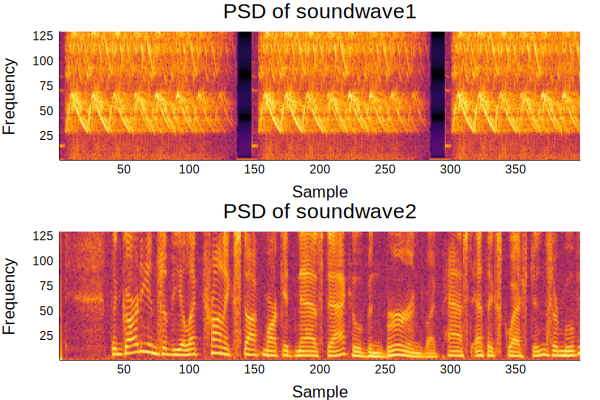

In [39]:
# PSD of original soundwaves
p1 = plot_spectrogram(x1, Int(fx1), "PSD of soundwave1")
p2 = plot_spectrogram(x2, Int(fx1), "PSD of soundwave2")
plot(p1, p2, layout = (2,1))

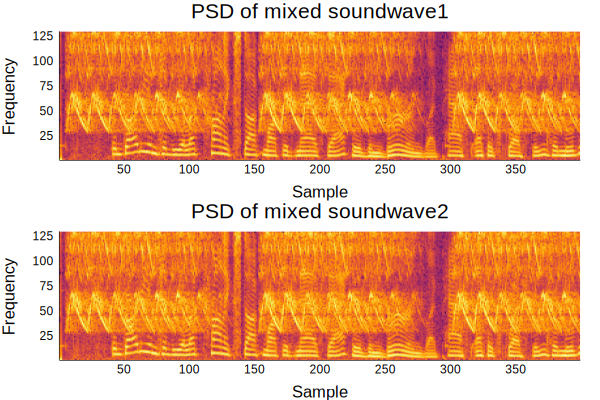

In [40]:
# PSD of original soundwaves
p3 = plot_spectrogram(z[1], Int(fx1), "PSD of mixed soundwave1")
p4 = plot_spectrogram(z[2], Int(fx1), "PSD of mixed soundwave2")
plot(p3, p4, layout = (2,1))

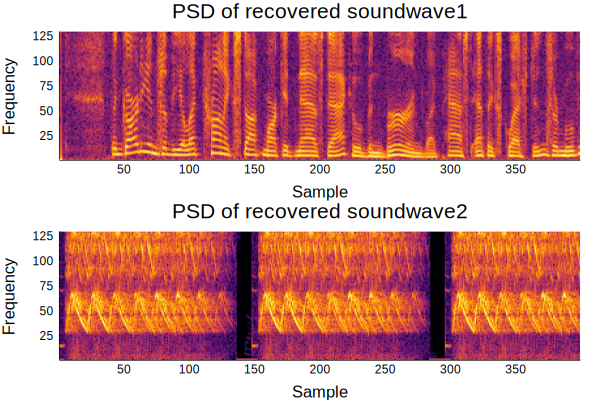

In [41]:
# PSD of recovered soundwaves by kurtosis-based fcf
p5 = plot_spectrogram(xest[1], Int(fx1), "PSD of recovered soundwave1")
p6 = plot_spectrogram(xest[2], Int(fx1), "PSD of recovered soundwave2")
plot(p5, p6, layout = (2,1))